In [1]:
%tensorflow_version 1.x
import tensorflow as tf
print("TensorFlow version of this code is:",tf.__version__)

#  ------------------- Importing libraries ------------------
import numpy as np
import matplotlib.pyplot as plt

# -------- the code below is for uploading the notMNIST.npz file to the code --------
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

TensorFlow 1.x selected.
TensorFlow version of this code is: 1.15.2


Saving notMNIST.npz to notMNIST (2).npz
User uploaded file "notMNIST.npz" with length 14698714 bytes


In [2]:
# ----------- the code below is for loading the dataset ----------------------------
def loadData():
    with np.load('notMNIST.npz') as dataset:
        Data, Target = dataset['images'], dataset['labels']
        posClass = 2
        negClass = 9
        dataIndx = (Target==posClass) + (Target==negClass)
        Data = Data[dataIndx]/255.
        Target = Target[dataIndx].reshape(-1, 1)
        Target[Target==posClass] = 1
        Target[Target==negClass] = 0
        np.random.seed(421)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data, Target = Data[randIndx], Target[randIndx]
        trainData, trainTarget = Data[:3500], Target[:3500]
        validData, validTarget = Data[3500:3600], Target[3500:3600]
        testData, testTarget = Data[3600:], Target[3600:]
    return trainData, validData, testData, trainTarget, validTarget, testTarget

In [3]:
def buildGraph(xdata, ydata, alpha, ADAM, beta_1=0.9, beta_2=0.999, epsilon=1e-08):
  global loss
  tf.set_random_seed(20)
  xdata_d = xdata.shape[1]

  # --------- Question 1 - Part a -------------------    
  #inializing weight and bias tensors
  w = tf.truncated_normal_initializer(mean=0, stddev=0.5)
  w = tf.get_variable("w", (xdata_d, 1), initializer=w)
  b = tf.constant_initializer(0.0)
  b = tf.get_variable("b", (1, ), initializer=b)

  # --------- Question 1 - Part b -------------------    
  # placeholders for data, label and reg
  x = tf.placeholder(tf.float32, shape=(None, xdata_d))
  y = tf.placeholder(tf.float32, shape=(None, 1))
  reg = tf.placeholder(tf.float32)

  # --------- Question 1 - Part c -------------------    
  # Loss function
  z = tf.add(tf.matmul(x, w), b)
  y_hat = tf.nn.sigmoid(z, name="y_hat")
  LCE = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=z)
  LCE = tf.reduce_mean(LCE) #cross entropy loss
  LW = (reg/2) * tf.reduce_sum(tf.square(w)) #regularizaton term loss
  loss = tf.add(LCE, LW) #total loss
  
  # --------- Question 1 - Part d -------------------    
  # optimizer
  if ADAM==True:
    optimizer = tf.train.AdamOptimizer(alpha, beta_1, beta_2, epsilon).minimize(loss)
  else:
    optimizer = tf.train.GradientDescentOptimizer(alpha).minimize(loss)

  return x, w, b, y_hat, y, loss, optimizer, reg

In [4]:
def lossValue(w, b, x, y, reg):
  z = (np.dot(x,w)) + b 
  y_hat_2 = 1/(1 + np.exp(-z))
  LCE_value = ((-1*y)*(np.log(y_hat_2))) - ((1 - y)*np.log(1- y_hat_2))
  LCE_value = np.mean(LCE_value) #cross entropy loss value

  w_norm = np.linalg.norm(w)  #takes the norm L2
  LW_value = (reg/2)*((w_norm)**2) #regularization loss
  L_value = LCE_value + LW_value # total loss
    
  return  y_hat_2 , L_value

In [5]:
def AccValue(w, b, x, y, reg):
  global trainData, validData, trainTarget, validTarget, testData, testTarget
  # loss data calculation for training and validation data and test data
  y_hat_train, L_train = lossValue(w, b, trainData, trainTarget, reg)
  y_hat_valid, L_valid = lossValue(w, b, validData, validTarget, reg)
  y_hat_test, L_test = lossValue(w, b, testData, testTarget, reg)

  # accuracy data calculation for training and validation data and test data
  y_hat_train[y_hat_train >= 0.5] = 1
  y_hat_train[y_hat_train < 0.5] = 0
  A_train = np.mean(y_hat_train == trainTarget)
  A_train = A_train*100

  y_hat_valid[y_hat_valid >= 0.5] = 1
  y_hat_valid[y_hat_valid < 0.5] = 0
  A_valid = np.mean(y_hat_valid == validTarget)
  A_valid = A_valid*100

  y_hat_test[y_hat_test >= 0.5] = 1
  y_hat_test[y_hat_test < 0.5] = 0
  A_test = np.mean(y_hat_test == testTarget)
  A_test = A_test*100

  return L_train, L_valid, A_train, A_valid, L_test, A_test


In [6]:
def SGD(batch_size, epochs, alpha, reg_2, ADAM, beta_1=0.9, beta_2=0.999, epsilon=1e-08):
  global trainData, validData, trainTarget, validTarget, testData, testTarget, loss_2, loss

  N = trainData.shape[0]
  total_batches = int(N/batch_size)
  iterations = total_batches * epochs

  x, w, b, y_hat, y, loss, optimizer, reg = buildGraph(trainData,trainTarget, alpha, ADAM, beta_1, beta_2, epsilon)

  global_init = tf.global_variables_initializer()
  L_train = []
  L_valid = []
  A_train = []
  A_valid = []
  L_test = []
  A_test = []

  with tf.Session() as sess:
    sess.run(global_init)
    for i in range(iterations):
      if (i+1)%total_batches == 0:
        shuffle_index = np.random.choice(N, N, replace=False)
        trainData, trainTarget = trainData[shuffle_index], trainTarget[shuffle_index]
      trainBatch, ybatch = trainData[:batch_size], trainTarget[:batch_size]

      _, w_2, b_2, loss_2 = sess.run([optimizer, w, b, loss], feed_dict={x:trainBatch, y:ybatch, reg:reg_2})
      trainData = np.roll(trainData, batch_size, axis=0)
      trainTarget = np.roll(trainTarget, batch_size, axis=0)

      if (i+1)%total_batches == 0:
        L_train_2, L_valid_2, A_train_2, A_valid_2, L_test_2, A_test_2 = AccValue(w_2, b_2, trainData, trainTarget, reg_2)
        L_train.append(L_train_2)
        L_valid.append(L_valid_2)
        A_train.append(A_train_2)
        A_valid.append(A_valid_2)
        L_test.append(L_test_2)
        A_test.append(A_test_2)

    w_updated, b_updated = sess.run([w, b])

  return w_updated, b_updated, L_train, L_valid, A_train, A_valid, L_test, A_test

In [7]:
def SGDgraph():
    w, b, L_train, L_valid, A_train, A_valid, L_test, A_test = SGD(batch_size=500, epochs=700, alpha=0.001, reg_2=0, ADAM=False)
    epochs=700
    print("Training Loss:  ", L_train[-1])
    print("Validation Loss:", L_valid[-1])
    print("Training Accuracy:  ", A_train[-1])
    print("Validation Accuracy:", A_valid[-1])
    print("Testing Loss:  ", L_test[-1])
    print("Testing Accuracy:", A_test[-1])

    xaxis = np.linspace(0, epochs, num=epochs)
    plt.plot(xaxis, L_train)
    plt.plot(xaxis, L_valid)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs. Number of Epochs')
    plt.legend(['trainData','validData'])
    plt.grid()
    plt.show()

    plt.plot(xaxis, A_train)
    plt.plot(xaxis,A_valid)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy vs. Number of Epochs')
    plt.legend(['trainData','validData'])
    plt.grid()
    plt.show()



In [8]:
def BatchSizeInvestigation():
  batchSizeInv = 1750 # Options: 100; 700; 1750
  epochs=700
  _, _, L_train, L_valid, A_train, A_valid, L_test, A_test = SGD(batch_size=1750, epochs=700, alpha=0.001, reg_2=0, ADAM=True)

  print("Batch size = ",batchSizeInv)
  print("Training Loss:  ", L_train[-1])
  print("Validation Loss:", L_valid[-1])
  print("Testing Loss:  ", L_test[-1])
  print("Training Accuracy:  ", A_train[-1])
  print("Validation Accuracy:", A_valid[-1])
  print("Testing Accuracy:", A_test[-1])

  xaxis = np.linspace(0, epochs, num=epochs)
  plt.plot(xaxis, L_train)
  plt.plot(xaxis, L_valid)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Loss vs. Number of Epochs, batch size = 1750')
  plt.legend(['trainData','validData'])
  plt.grid()
  plt.show()

  plt.plot(xaxis, A_train)
  plt.plot(xaxis,A_valid)
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy (%)')
  plt.title('Accuracy vs. Number of Epochs, batch size = 1750')
  plt.legend(['trainData','validData'])
  plt.grid()
  plt.show()



In [9]:
def HyperparameterInvestigation():
  #beta1 = 0.99 # Options: 0.95; 0.99
  #beta2 = 0.9999 # Options: 0.99; 0.9999
  epsilon2 = 1e-4 # Options: 1e-09; 1e-4
  epochs=700

  _, _, L_train, L_valid, A_train, A_valid, L_test, A_test = SGD(batch_size=500, epochs=700, alpha=0.001, reg_2=0, ADAM=True, epsilon=1e-4)

  #print("Beta_1 = ",beta1)
  #print("Beta_2 = ",beta2)
  print("epsilon = ",epsilon2)

  print("Training Loss:  ", L_train[-1])
  print("Validation Loss:", L_valid[-1])
  print("Training Accuracy:  ", A_train[-1])
  print("Validation Accuracy:", A_valid[-1])
  print("Testing Loss:  ", L_test[-1])
  print("Testing Accuracy:", A_test[-1])

  xaxis = np.linspace(0, epochs, num=epochs)
  plt.plot(xaxis, L_train)
  plt.plot(xaxis, L_valid)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Loss vs. Number of Epochs, epsilon = 1e-4')
  plt.legend(['trainData','validData'])
  plt.grid()
  plt.show()

  plt.plot(xaxis, A_train)
  plt.plot(xaxis,A_valid)
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy (%)')
  plt.title('Accuracy vs. Number of Epochs, epsilon = 1e-4')
  plt.legend(['trainData','validData'])
  plt.grid()
  plt.show()



In [10]:
def ComparisonAgainstBatchGD():
  epochs=5000
  _, _, L_train, L_valid, A_train, A_valid, L_test, A_test = SGD(batch_size=3500, epochs=5000, alpha=0.001, reg_2=0, ADAM=True)

  print("Training Loss:  ", L_train[-1])
  print("Validation Loss:", L_valid[-1])
  print("Training Accuracy:  ", A_train[-1])
  print("Validation Accuracy:", A_valid[-1])
  print("Testing Loss:  ", L_test[-1])
  print("Testing Accuracy:", A_test[-1])

  xaxis = np.linspace(0, epochs, num=epochs)
  plt.plot(xaxis, L_train)
  plt.plot(xaxis, L_valid)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Loss for ADAM - epochs = 5000, alpha = 0.001, reg = 0')
  plt.legend(['trainData','validData'])
  plt.grid()
  plt.show()

  plt.plot(xaxis, A_train)
  plt.plot(xaxis,A_valid)
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy (%)')
  plt.title('Accuracy for ADAM - epochs = 5000, alpha = 0.001, reg = 0')
  plt.legend(['trainData','validData'])
  plt.grid()
  plt.show()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Training Loss:   0.0121416968955992
Validation Loss: 0.10293358839912772
Training Accuracy:   99.62857142857143
Validation Accuracy: 97.0
Testing Loss:   0.157185817374578
Testing Accuracy: 97.93103448275862


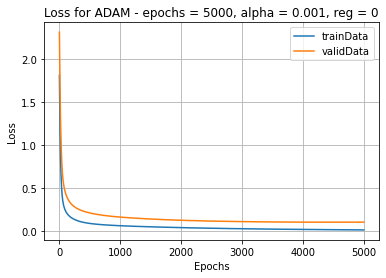

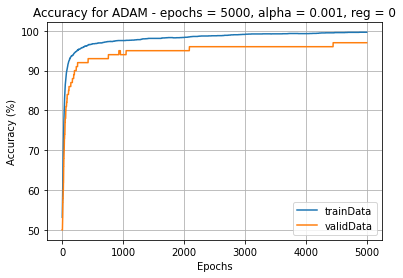

In [11]:
if __name__ == "__main__":
  trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()
  trainData = trainData.reshape(np.shape(trainData)[0],-1)
  validData = validData.reshape(np.shape(validData)[0],-1)
  testData = testData.reshape(np.shape(testData)[0],-1)

  #SGDgraph()
  #BatchSizeInvestigation()
  #HyperparameterInvestigation()
  ComparisonAgainstBatchGD()
